## Environment Setup

In [96]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.insert (0, './_functions_/')
from functions_electric_cars import *

## Datasets

In [97]:
df = merge_excel_sheets("./raw_data/02__autos_nach_bundesland_kraftstoff.xlsx")
df.head()

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019


## Handling missing values

Check for NaNs

In [98]:
df.isnull().sum()

Land                            0
Kraftstoffart                 126
Kraftfahrzeuge \ninsgesamt      0
Year                            0
dtype: int64

The lines that contain no Kraftstoffart are the ones that include totals, therefore we will replace with the value 'Total'

In [99]:
# the lines that contain no Kraftstoffart are the ones that include totals, therefore we will replace with the value 'Total'
df['Kraftstoffart'] = df['Kraftstoffart'].fillna('Total') 
df

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [100]:
#remove the text "zusammen" or "insgesamt" from the Land
df['Land'] = df['Land'].str.replace(r'\s+zusammen$', '', regex=True)
df['Land'] = df['Land'].str.replace(r'\s+insgesamt$', '', regex=True)


In [101]:
# Remove "Sonstige" from the dataset,since we are interested in the german states
df = df[~(df["Land"] =="Sonstige")]
df

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [102]:
df ['Kraftstoffart'].value_counts()

Kraftstoffart
Benzin                119
Diesel                119
Gas insgesamt         119
Hybrid insgesamt      119
Total                 119
Sonstige              119
Elektro (BEV)          85
darunter Plug-in       85
Elektro                34
  darunter Plug-in     34
Name: count, dtype: int64

In [103]:
df = df.rename(columns ={'Land':'land', 'Kraftstoffart':'fuel', 'Kraftfahrzeuge \ninsgesamt': 'total_cars', 'Year':'year'})
df

,land,fuel,total_cars,year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [104]:
# harmonize the types of "fuel"

fuel_type_mapping = {
 'Benzin': 'Benzin', 
 'Diesel': 'Diesel', 
 'Gas insgesamt': 'Gas', 
 'Hybrid insgesamt': 'Hybrid total', 
 'Sonstige': 'Sonstige',
 'Elektro (BEV)': 'Electric', 
 'Elektro': 'Electric', 
 'darunter Plug-in': 'Plug-in Hybrid',
 '  darunter Plug-in': 'Plug-in Hybrid'  
 }

df['fuel'] = df['fuel'].replace(fuel_type_mapping)
df["fuel"].value_counts()


fuel
Benzin            119
Diesel            119
Gas               119
Electric          119
Hybrid total      119
Plug-in Hybrid    119
Sonstige          119
Total             119
Name: count, dtype: int64

In [105]:
df

,land,fuel,total_cars,year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas,49062,2019
3,Baden-Württemberg,Electric,19508,2019
4,Baden-Württemberg,Hybrid total,52055,2019
...,...,...,...,...
1003,Deutschland,Electric,1810815,2025
1004,Deutschland,Hybrid total,3573138,2025
1005,Deutschland,Plug-in Hybrid,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [106]:
# one df for deutschland
df_germany = df [df ["land"] =="Deutschland"].reset_index()
df_germany.head(8)

,index,land,fuel,total_cars,year
0,136,Deutschland,Benzin,35732397,2019
1,137,Deutschland,Diesel,20591834,2019
2,138,Deutschland,Gas,507768,2019
3,139,Deutschland,Electric,112119,2019
4,140,Deutschland,Hybrid total,342555,2019
5,141,Deutschland,Plug-in Hybrid,67075,2019
6,142,Deutschland,Sonstige,18528,2019
7,143,Deutschland,Total,57305201,2019


In [107]:
df_states = df [~(df ["land"] =="Deutschland")].reset_index()
df_states

,index,land,fuel,total_cars,year
0,0,Baden-Württemberg,Benzin,5003238,2019
1,1,Baden-Württemberg,Diesel,2984960,2019
2,2,Baden-Württemberg,Gas,49062,2019
3,3,Baden-Württemberg,Electric,19508,2019
4,4,Baden-Württemberg,Hybrid total,52055,2019
...,...,...,...,...,...
891,987,Thüringen,Electric,23915,2025
892,988,Thüringen,Hybrid total,73958,2025
893,989,Thüringen,Plug-in Hybrid,15529,2025
894,990,Thüringen,Sonstige,449,2025


In [108]:
# we consider electric and hybrid as electrical, since they all use the charging stations
electric_types = ["Electric", "Plug-in Hybrid"]

# filter the electrical vehicles
eautos = df_germany [df_germany["fuel"].isin(electric_types)]
# summs the electrical vehicles
e_autos_germany = eautos.groupby("year").agg(
    number_of_electric_cars=("total_cars", "sum")      
).reset_index()

e_autos_germany


,year,number_of_electric_cars
0,2019,179194
1,2020,276912
2,2021,638647
3,2022,1250511
4,2023,2005289
5,2024,2478141
6,2025,2779549


In [109]:
total_autos = df_germany [df_germany["fuel"] == 'Total']
total_autos


,index,land,fuel,total_cars,year
7,143,Deutschland,Total,57305201,2019
15,287,Deutschland,Total,58158344,2020
23,431,Deutschland,Total,59020091,2021
31,575,Deutschland,Total,59635446,2022
39,719,Deutschland,Total,60133124,2023
47,863,Deutschland,Total,60680636,2024
55,1007,Deutschland,Total,61097943,2025


In [110]:
total_autos.drop(columns = ['land', 'fuel'], inplace = True)
total_autos.reset_index(drop=True)
total_autos

,index,total_cars,year
7,143,57305201,2019
15,287,58158344,2020
23,431,59020091,2021
31,575,59635446,2022
39,719,60133124,2023
47,863,60680636,2024
55,1007,61097943,2025


In [111]:
total_cars_germany = total_autos.merge(e_autos_year, on ='year', how = 'left')
total_cars_germany

,index,total_cars,year,number_of_electric_cars
0,143,57305201,2019,179194
1,287,58158344,2020,276912
2,431,59020091,2021,638647
3,575,59635446,2022,1250511
4,719,60133124,2023,2005289
5,863,60680636,2024,2478141
6,1007,61097943,2025,2779549


In [112]:
total_cars_germany.to_csv("./clean_data/total_cars_germany.csv", index = False)

In [113]:
charging_stations_germany = pd.read_csv('./clean_data/stations_germany.csv', usecols= ['number_of_charging_points', 'year'])

charging_stations_germany = charging_stations_germany [charging_stations_germany["year"] > 2018]

charging_stations_germany = charging_stations_germany.merge(e_autos_year, on = "year", how = "left")

charging_stations_germany

,number_of_charging_points,year,number_of_electric_cars
0,19812,2019,179194
1,31006,2020,276912
2,44528,2021,638647
3,62099,2022,1250511
4,89913,2023,2005289
5,130504,2024,2478141
6,160809,2025,2779549


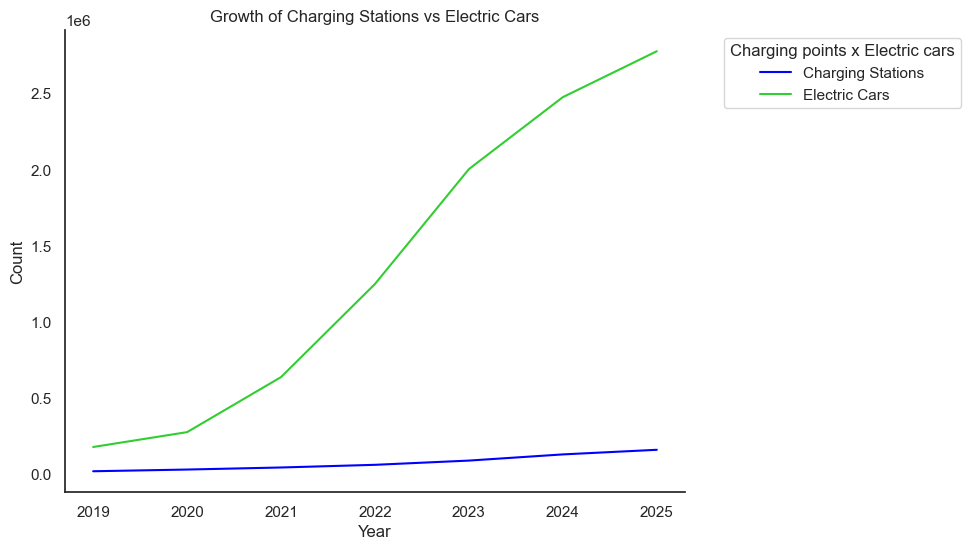

In [114]:
plt.figure(figsize=(8, 6))
sns.lineplot(data = charging_stations_germany, x ='year', y ='number_of_charging_points', label='Charging Stations', color = "blue")
sns.lineplot(data = charging_stations_germany, x ='year', y = 'number_of_electric_cars', label='Electric Cars', color = color_eletric)
sns.despine()

plt.xlabel('Year')
plt.ylabel('Count')


plt.title('Growth of charging stations vs electric cars')

# Move legend outside
plt.legend(title="Charging points x Electric cars", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [115]:

df = total_cars_germany

# Sort by year in case it's not sorted
df = df.sort_values('year')

# Compute the number of new cars and new electric cars per year
df['new_total_cars'] = df['total_cars'].diff()
df['new_electric_cars'] = df['number_of_electric_cars'].diff()
# Compute percentage of new electric cars
#df['percent_new_electric'] = (df['new_electric_cars'] / df['new_total_cars']) * 100
df



,index,total_cars,year,number_of_electric_cars,new_total_cars,new_electric_cars
0,143,57305201,2019,179194,NaN,NaN
1,287,58158344,2020,276912,853143.0,97718.0
2,431,59020091,2021,638647,861747.0,361735.0
3,575,59635446,2022,1250511,615355.0,611864.0
4,719,60133124,2023,2005289,497678.0,754778.0
5,863,60680636,2024,2478141,547512.0,472852.0
6,1007,61097943,2025,2779549,417307.0,301408.0


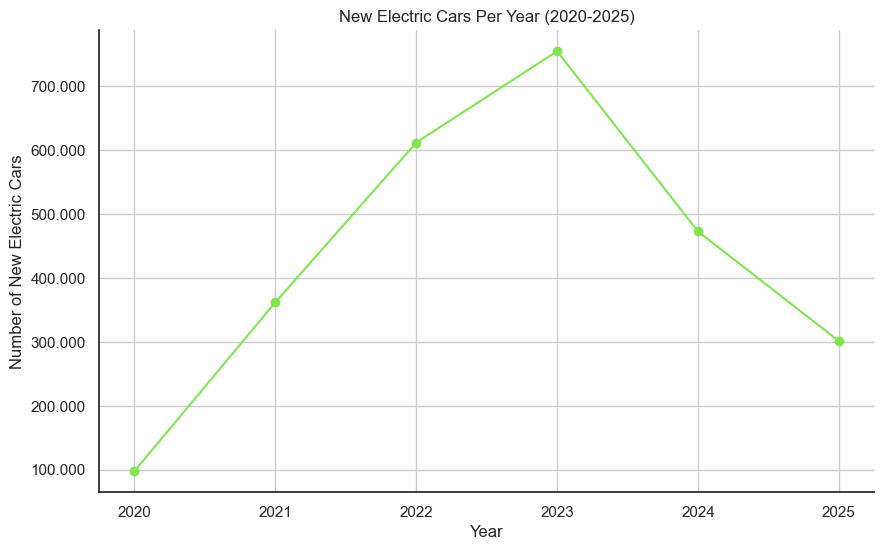

In [116]:


# Drop the first row with NaN from diff
df = df.dropna()

def european_thousands(x, pos):
    return f'{x:,.0f}'.replace(',', '.')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['new_electric_cars'], marker='o', color = '#81E552')

ax = plt.gca();
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FuncFormatter(european_thousands))


plt.title('New electric cars per year (2020-2025)')
plt.xlabel('Year')
plt.ylabel('Number of New Electric Cars')
plt.grid(True)
plt.show()

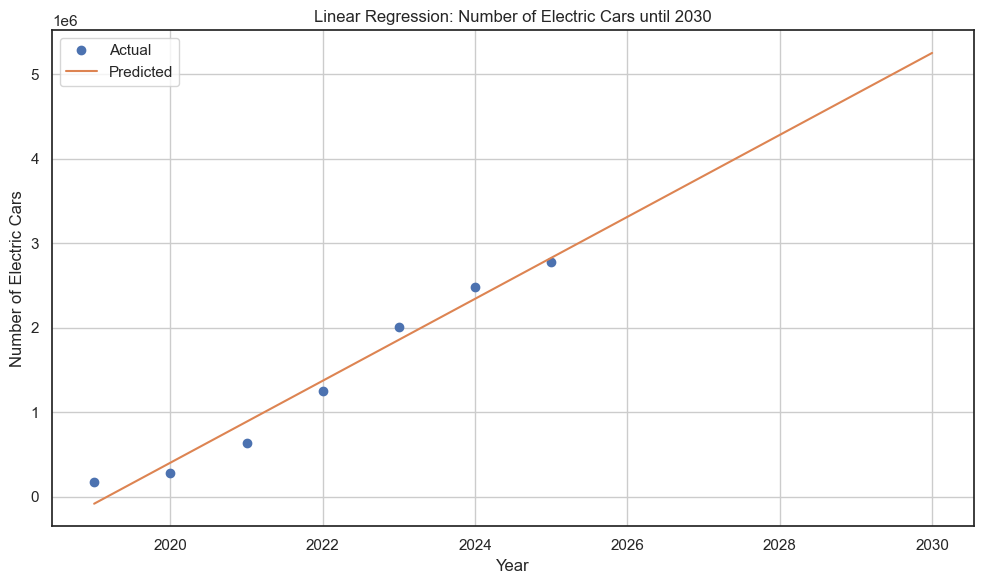

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

df = charging_stations_germany

# Train linear regression on year vs number_of_electric_cars
X = df[['year']]
y = df['number_of_electric_cars']

model = LinearRegression()
model.fit(X, y)

# Predict up to 2030
future_years = np.arange(2019, 2031).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['number_of_electric_cars'], 'o', label='Actual')
plt.plot(future_years.flatten(), future_predictions, '-', label='Predicted')

plt.title("Linear Regression: Number of Electric Cars until 2030")
plt.xlabel("Year")
plt.ylabel("Number of Electric Cars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


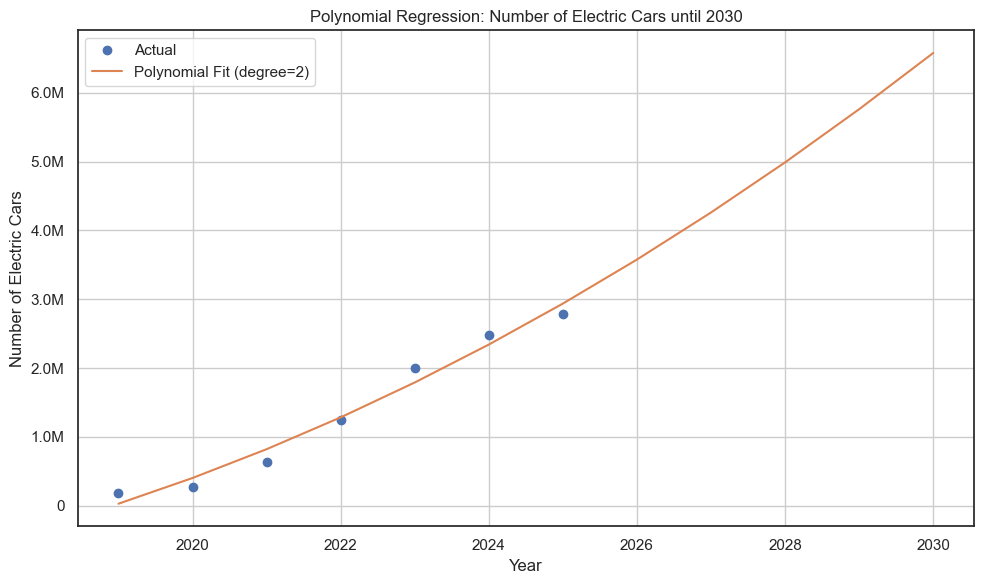

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.ticker import ScalarFormatter

from matplotlib.ticker import FuncFormatter

# Function to convert large numbers to 'M' format
def millions_formatter(x, pos):
    return f'{x*1e-6:.1f}M' if x >= 1e6 else f'{int(x)}'
    

df = charging_stations_germany

# Set up polynomial regression (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df[['year']])
y = df['number_of_electric_cars']

model = LinearRegression()
model.fit(X_poly, y)

# Predict up to 2030
future_years = np.arange(2019, 2031).reshape(-1, 1)
future_X_poly = poly.transform(future_years)
future_predictions = model.predict(future_X_poly)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['number_of_electric_cars'], 'o', label='Actual')
plt.plot(future_years.flatten(), future_predictions, '-', label='Polynomial Fit (degree=2)')

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.title("Polynomial Regression: Number of Electric Cars until 2030")
plt.xlabel("Year")
plt.ylabel("Number of Electric Cars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

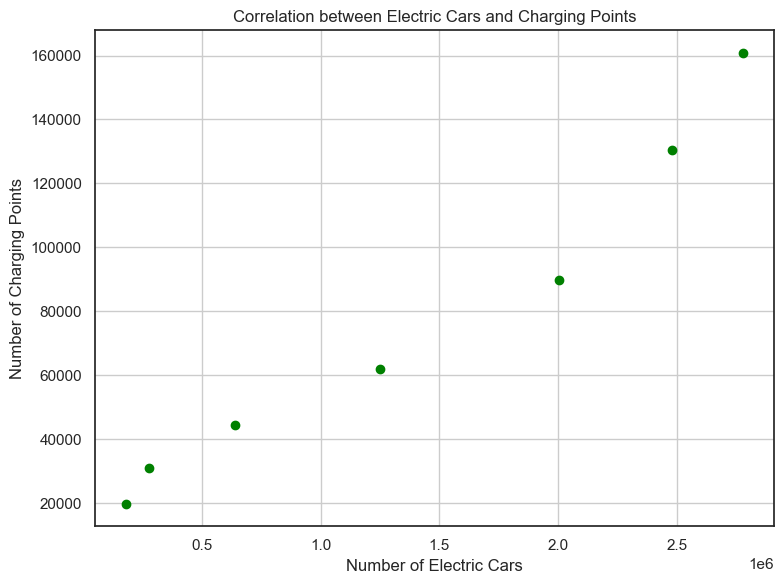

In [119]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(charging_stations_germany['number_of_electric_cars'], charging_stations_germany['number_of_charging_points'], color='green')
plt.title('Correlation between Electric Cars and Charging Points')
plt.xlabel('Number of Electric Cars')
plt.ylabel('Number of Charging Points')
plt.grid(True)
plt.tight_layout()
plt.show()

In [120]:
correlation = charging_stations_germany['number_of_electric_cars'].corr(charging_stations_germany['number_of_charging_points'])
print(f'Correlation: {correlation:.2f}')

Correlation: 0.98


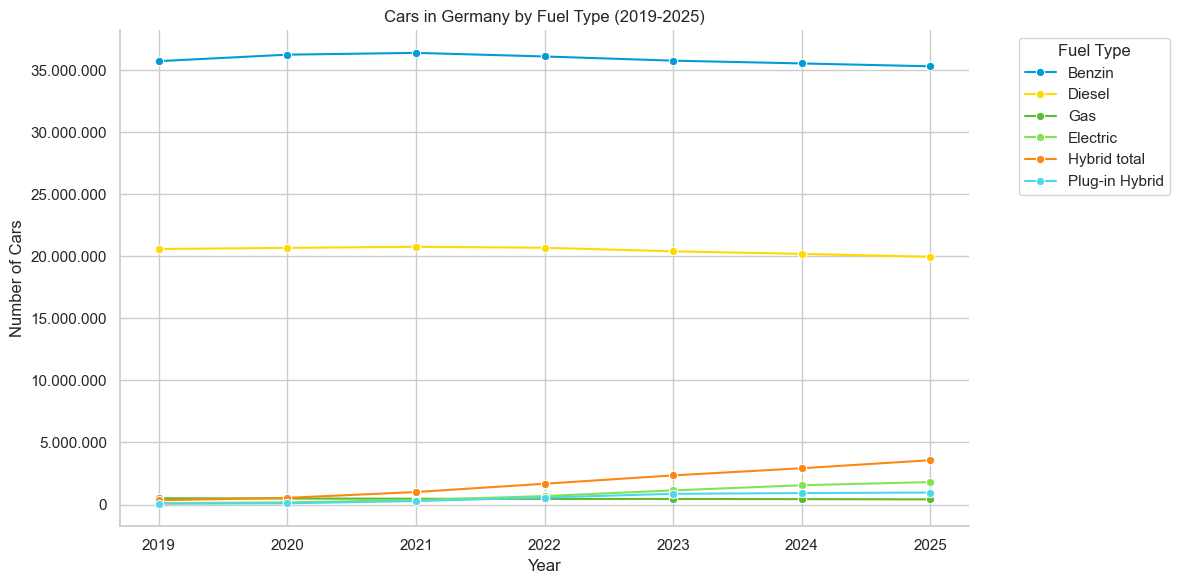

In [127]:
# Set the plot style
#sns.set_style("whitegrid")

def european_thousands(x, pos):
    return f'{x:,.0f}'.replace(',', '.')
    
# excludes total, as it includes all the fuel types
df_germany_filtered = df_germany[~(df_germany["fuel"].isin(["Total","Sonstige"]))]

# Pivot the data to get years on x-axis and fuel types as separate lines
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_germany_filtered, x="year", y="total_cars", palette = colors_fuel, hue="fuel", marker="o")

# Access the axes
ax = plt.gca()

# Turn off scientific notation
ax.ticklabel_format(style='plain', axis='y')

# Format ticks with commas
ax.yaxis.set_major_formatter(FuncFormatter(european_thousands))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Cars")
plt.title("Cars in Germany by Fuel Type (2019-2025)")

# Move legend outside
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to fit legend
plt.tight_layout()
plt.show()

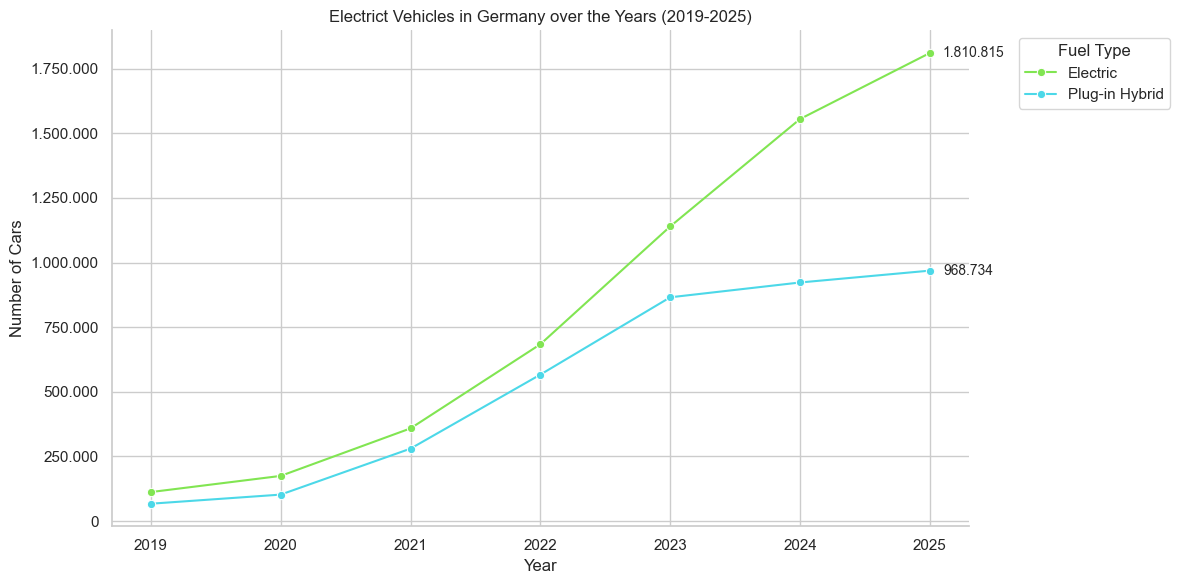

In [131]:
import matplotlib.ticker as ticker

# here we consider pure electrical and plug-in hybrids as electrical cars
df_electric = df_germany[df_germany["fuel"].isin(["Electric", "Plug-in Hybrid"])]

# Set the plot style
#sns.set_style("whitegrid")


# Pivot the data to get years on x-axis and fuel types as separate lines
plt.figure(figsize=(12, 6))

# Access the axes
ax = plt.gca()

# Turn off scientific notation
ax.ticklabel_format(style='plain', axis='y')

# Format ticks with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))


sns.lineplot(data=df_electric, x="year", y="total_cars", palette = colors_fuel, hue="fuel", marker="o", ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Cars")
plt.title("Electrict Vehicles in Germany over the Years (2019-2025)")

# Move legend outside
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to fit legend
plt.tight_layout()

# Annotate the last value of each line
for fuel_type, group_data in df_electric.groupby("fuel"):
    last_point = group_data.sort_values("year").iloc[-1]
    x = last_point["year"]
    y = last_point["total_cars"]
    label = f'{int(y):,}'.replace(',', '.')

    # Slight offset to avoid overlapping with the point
    ax.text(x + 0.1, y, label, va='center', fontsize=10)


plt.show()

In [ ]:
# Remove "Deutschland" from the dataset, as it contains aggregations
df_states = df[~(df["land"] =="Deutschland")]
df_states

In [ ]:
df_states.to_csv('./clean_data/cars_based_on_fuel_per_year.csv',  index=False)

Since we are only interested in E-Autos and the rest, we will convert the data again

In [ ]:
fuel_type_mapping2 = {
 'Benzin': 'Others', 
 'Diesel': 'Others', 
 'Gas': 'Others',  
 'Sonstige': 'Others',
 'Hybrid': 'Others',  
 'Electric': 'Electric',
 'Hybrid E': 'Plug-in Hybrid'  
 }

df_states['fuel'] = df_states['fuel'].replace(fuel_type_mapping2)
df_states["fuel"].value_counts()

In [ ]:
df_states.to_csv('./clean_data/cars_based_on_fuel_per_year_filtered.csv',  index=False)

In [ ]:
# Filter data for 2025
df_2025 = df_states[df_states["year"] == 2025]

# Sort by total number of cars for better visualization
df_2025 = df_2025.sort_values(by="total_cars", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_2025, x="total_cars", y="land", palette=german_states_colors)

# Labels and title
plt.xlabel("Total Cars")
plt.ylabel("Land")
plt.title("Total Number of Cars per State (2025)")

# Show the plot
plt.show()


In [ ]:
df_states['fuel'].value_counts()


In [ ]:
# Filter data for 2025
df_2025 = df_states[df_states["year"] == 2025]

# Pivot table to get total cars by fuel type for each Land
df_pivot = df_2025.pivot_table(index="land", columns="fuel", values="total_cars", aggfunc="sum")

# Sort by total number of cars for better visualization
df_pivot = df_pivot.sort_values(by="Total", ascending=True)

# Handle missing values (if some states don't have electric cars)
df_pivot = df_pivot.fillna(0)

# Compute non-electric cars
df_pivot["Non_Electric"] = df_pivot["Total"] - df_pivot["Electric"]

# Plot stacked bar chart
plt.figure(figsize=(12, 6))

plt.barh(df_pivot.index, df_pivot["Non_Electric"], color="lightgray", label="Other Fuels")
plt.barh(df_pivot.index, df_pivot["Electric"], left=df_pivot["Non_Electric"], color="#81E552", label="Electric")

# Labels and title
plt.xlabel("Total Cars (in 10 milions)")
plt.ylabel("State")
plt.title("Total Number of Cars per State (2025)")
plt.legend()

# Show the plot
plt.show()



### Creates a new dataframe

Creates a Dataframe with the information about the year 2025

In [ ]:
autos_2025 = df_states [df_states["year"] == 2025]
autos_2025.rename(columns = {"land":"state"}, inplace=True)

# we consider electric and hybrid as electrical, since they all use the charging stations
electric_types = ["Electric", "Plug-in Hybrid"]

# filter the electrical vehicles
eautos_2025 = autos_2025[autos_2025["fuel"].isin(electric_types)]
# summs the electrical vehicles
e_autos_per_state_2025 = eautos_2025.groupby("state").agg(
    number_of_electric_cars=("total_cars", "sum")     
).reset_index()

e_autos_per_state_2025.head()



In [ ]:
# filter the total of cars
total_cars_2025 = autos_2025 [autos_2025['fuel'] == 'Total']
total_cars_2025.drop(columns=['fuel', 'year'], inplace=True)                    
                     

Merges the total of electrical cars with the total of cars, and adds a column total of non-electric

In [ ]:
autos_state_2025 = e_autos_per_state_2025.merge(total_cars_2025, on = "state", how="left")
autos_state_2025


In [ ]:
autos_state_2025['number_non_electric_cars'] = autos_state_2025['total_cars'] - autos_state_2025['number_of_electric_cars']
autos_state_2025.rename (columns = {'total_cars':'number_cars'}, inplace = True)
autos_state_2025


In [ ]:
autos_state_2025.to_csv("./clean_data/autos_state_2025.csv", index = False)

In [ ]:
def plot_stacked_bar_for_state(df, land, colors):
    """
    Creates a stacked bar plot showing the number of electric vs. other fuel cars over different years for a given Land.

    Parameters:
        df (pd.DataFrame): The dataset containing columns 'Land', 'Fuel', 'Total cars', and 'Year'.
        land (str): The name of the Land (state) to visualize.
        german_states_colors (dict): A dictionary mapping German states to colors.
    """

    # Filter data for the selected Land
    df_land = df[df["land"] == land]

    # Pivot table to get fuel types as columns and years as index
    df_pivot = df_land.pivot_table(index="year", columns="fuel", values="total_cars", aggfunc="sum")

    # Handle missing values (if some years don't have electric cars)
    df_pivot = df_pivot.fillna(0)

    # Compute non-electric cars
    df_pivot["Non_Electric"] = df_pivot["Total"] - df_pivot["Electric"]

    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Set bar width
    bar_width = 0.5  # Adjusted from default 0.8 to make bars slimmer
    
    # Plot "Non_Electric" in the state's assigned color
    plt.bar(df_pivot.index, df_pivot["Non_Electric"], color=german_states_colors.get(land, "black"), label="Other Fuels", width=bar_width)

    # Plot "Electric" on top in gray
    plt.bar(df_pivot.index, df_pivot["Electric"], bottom=df_pivot["Non_Electric"], color="gray", label="Electric", width=bar_width)


    # Add text labels for electric percentage
    for year in df_pivot.index:
        total = df_pivot.loc[year, "Total"]
        electric = df_pivot.loc[year, "Electric"]
        percent = (electric / total) * 100 if total > 0 else 0

        plt.text(year, total * 1.02, f"{percent:.1f}%", ha='center', fontsize=10, color="black")

    # Labels and title
    plt.xlabel("Year")
    plt.ylabel("Total Cars")
    plt.title(f"Electric vs Other Cars in {land} Over the Years")
    plt.xticks(df_pivot.index)  # Ensure all years are shown
    plt.legend()

    # Show the plot
    plt.show()


In [ ]:
plot_stacked_bar_for_state(df = df_states, land ='Bayern', colors= german_states_colors)

In [ ]:
plot_stacked_bar_for_state(df = df_states, land ='Nordrhein-Westfalen', colors= german_states_colors)

In [ ]:
import matplotlib.pyplot as plt

def plot_line_chart_for_state(df, land, colors):
    """
    Creates a line chart showing the number of electric vs. other fuel cars over different years for a given Land.

    Parameters:
        df (pd.DataFrame): The dataset containing columns 'Land', 'Fuel', 'Total cars', and 'Year'.
        land (str): The name of the Land (state) to visualize.
        colors (dict): A dictionary mapping fuel types to colors for the line chart.
    """

    # Filter data for the selected Land
    df_land = df[df["land"] == land]

    # Pivot table to get fuel types as columns and years as index
    df_pivot = df_land.pivot_table(index="year", columns="fuel", values="total_cars", aggfunc="sum")

    # Handle missing values (if some years don't have electric cars)
    df_pivot = df_pivot.fillna(0)

    # Compute non-electric cars
    if "Electric" in df_pivot.columns:
        df_pivot["Non_Electric"] = df_pivot["Total"] - df_pivot["Electric"]
    else:
        df_pivot["Non_Electric"] = df_pivot["Total"]  # If no electric data exists, assume all cars are non-electric

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot line chart for "Non_Electric" cars
    plt.plot(df_pivot.index, df_pivot["Non_Electric"], color=german_states_colors.get(land, "black"), label="Other Fuels", marker='o')

    # Plot line chart for "Electric" cars
    plt.plot(df_pivot.index, df_pivot["Electric"], color="gray", label="Electric", marker='o')

    # Add text labels for electric percentage on each point
    for year in df_pivot.index:
        total = df_pivot.loc[year, "Total"]
        electric = df_pivot.loc[year, "Electric"]
        percent = (electric / total) * 100 if total > 0 else 0
        plt.text(year, electric + 0.05 * total, f"{percent:.1f}%", ha='center', fontsize=10, color="black")

    # Labels and title
    plt.xlabel("Year")
    plt.ylabel("Total Cars")
    plt.title(f"Electric vs Other Cars in {land} Over the Years")
    plt.xticks(df_pivot.index)  # Ensure all years are shown
    plt.legend()

    # Show the plot
    plt.show()


In [ ]:
plot_line_chart_for_state(df = df_states, land ='Nordrhein-Westfalen', colors= german_states_colors)

In [ ]:
plot_line_chart_for_state(df = df_states, land ='Bayern', colors= german_states_colors)

In [ ]:
# Filter for electric and plug-in hybrid cars
electric_types = ["Electric", "Plug-in Hybrid"]
df_total_electric = df_states[df_states["fuel"].isin(electric_types)]

# Group by land and year to get total electric cars
electric_summary = df_total_electric.groupby(["land", "year"])["total_cars"].sum().reset_index()
electric_summary.rename(columns={"total_cars": "total_electric"}, inplace=True)



In [ ]:
# Check for rows where the fuel column is "Total"
df_total_flag = df_states[df_states["fuel"].str.lower() == "total"]

# Keep only these rows as the actual total per state/year
total_cars_summary_corrected = df_total_flag[["land", "year", "total_cars"]].copy()
total_cars_summary_corrected.rename(columns={"total_cars": "total_all"}, inplace=True)

# Reuse the already computed total electric (electric + plug-in hybrid)
# electric_summary is already grouped by land and year
# Merge with the corrected total cars
merged_df_corrected = pd.merge(total_cars_summary_corrected, electric_summary, on=["land", "year"], how="left")
merged_df_corrected["total_electric"] = merged_df_corrected["total_electric"].fillna(0).astype(int)
merged_df_corrected["total_non_electric"] = merged_df_corrected["total_all"] - merged_df_corrected["total_electric"]

# Select and reorder columns
final_df_corrected = merged_df_corrected[["land", "total_electric", "total_non_electric", "year"]]

final_df_corrected.head()


In [ ]:
final_df_corrected.shape

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for plotting
plot_df = final_df_corrected.melt(id_vars=["land", "year"],
                                  value_vars=["total_electric", "total_non_electric"],
                                  var_name="Type",
                                  value_name="Count")

# Create a color palette
palette = {"total_electric": "green", "total_non_electric": "gray"}

# Plot: Evolution per year (aggregated across all states)
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="year", y="Count", hue="Type", estimator=sum, palette=palette)

plt.title("Electric vs Non-Electric Car Count Evolution in Germany")
plt.ylabel("Total Number of Cars")
plt.xlabel("Year")
plt.legend(title="Vehicle Type", labels=["Electric + Plug-in Hybrid", "Other"], bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()